Might be useful

http://classic.sdss.org/dr6/algorithms/linestable.html

https://ned.ipac.caltech.edu/level5/Cambridge/Cambridge1_3_4.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from modules import Sed, get_bandpass_dict
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.integrate import simps

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35
plt.rcParams["figure.figsize"] = [4.5, 4.5]

In [3]:
bandpass_dict = get_bandpass_dict()

(50, 11000)

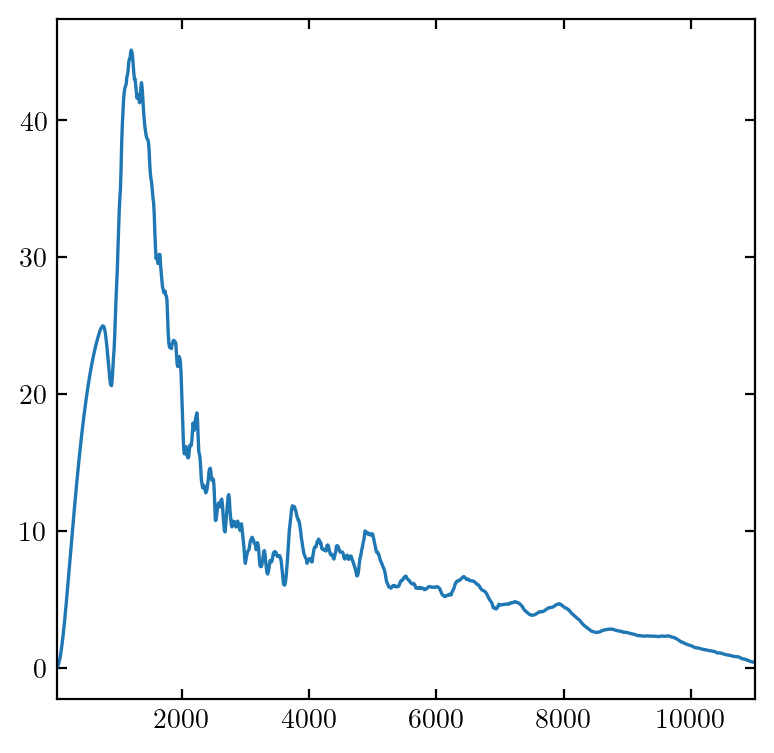

In [4]:
templateN = '20'
x,y = np.loadtxt('templates/naive'+templateN+'.sed',unpack=True)

plt.plot(x,y)
plt.xlim(50,11000)

In [21]:
def idx_closest(x,array):
    return np.fabs(np.array(array)-x).argmin()

def get_continuum(sed,window,buffer=500,order=2):
    
    idxlo1 = idx_closest(window[0]-buffer,sed.wavelen)
    idxhi1 = idx_closest(window[0],sed.wavelen)  
    idxlo2 = idx_closest(window[1],sed.wavelen)
    idxhi2 = idx_closest(window[1]+buffer,sed.wavelen)
    
    x = np.concatenate((sed.wavelen[idxlo1:idxhi1],sed.wavelen[idxlo2:idxhi2]))
    y = np.concatenate((sed.flambda[idxlo1:idxhi1],sed.flambda[idxlo2:idxhi2]))
    
    continuum = np.polynomial.Chebyshev.fit(x,y,deg=order)
    return continuum

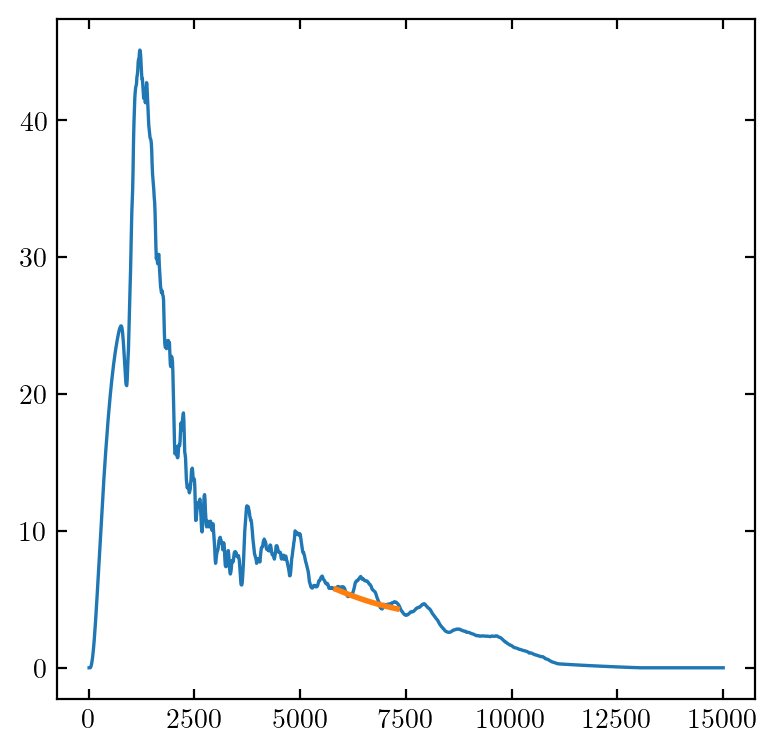

In [22]:
Halpha_lo = 5850
Halpha_hi = 7300

f = get_continuum(Sed(x,y),[Halpha_lo,Halpha_hi])

idxlo = idx_closest(Halpha_lo,x)
idxhi = idx_closest(Halpha_hi,x)
plt.plot(x,y)
plt.plot(x[idxlo:idxhi],f(x[idxlo:idxhi]),lw=2)

In [25]:
def get_subtracted(sed,window,buffer=500,order=2):
    
    subtracted = copy.deepcopy(sed)
    
    idxlo = idx_closest(window[0],subtracted.wavelen)
    idxhi = idx_closest(window[1],subtracted.wavelen)
    
    subtracted.flambda[:idxlo] *= 0
    subtracted.flambda[idxhi:] *= 0
    
    continuum = get_continuum(sed,window,buffer,order)
    subtracted.flambda[idxlo:idxhi] -= continuum(subtracted.wavelen[idxlo:idxhi])
    
    return subtracted

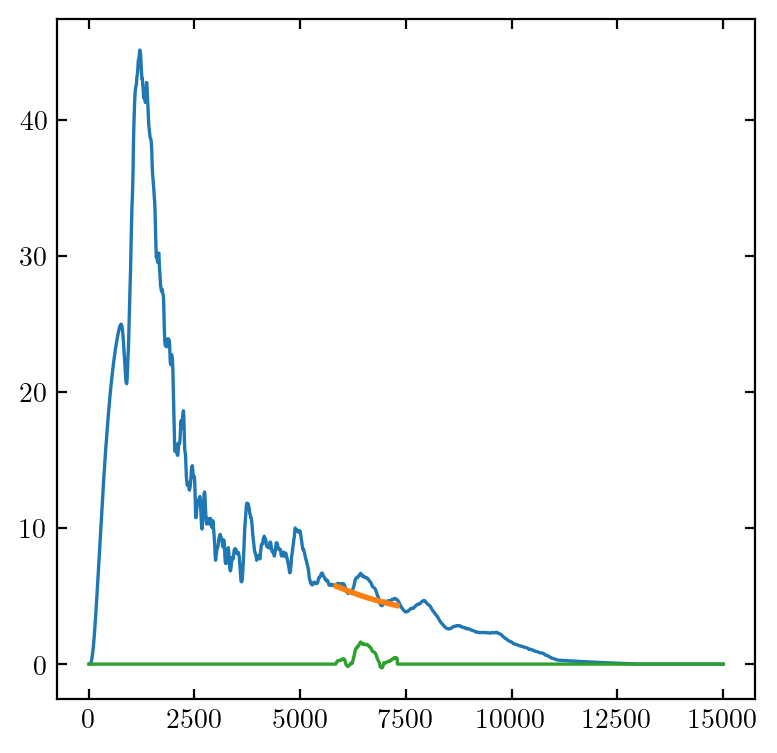

In [26]:
subtracted = get_subtracted(Sed(x,y),[Halpha_lo,Halpha_hi])

idxlo = idx_closest(Halpha_lo,x)
idxhi = idx_closest(Halpha_hi,x)
plt.plot(x,y)
plt.plot(x[idxlo:idxhi],f(x[idxlo:idxhi]),lw=2)

plt.plot(subtracted.wavelen,subtracted.flambda)

In [42]:
def line_photometry(x,wavelen,FWHM=30,maxz=3):
    
    sig = FWHM/2.355
    
    lineSED = Sed(x,0*x)
    gaussian = lambda x: np.exp(-(x-wavelen)**2/(2*sig**2))
    lineSED.flambda += gaussian(lineSED.wavelen)

    wavelens = np.array([])
    fluxes = np.array([])
    for z in np.linspace(0,maxz,500):
        lineSED_ = copy.deepcopy(lineSED)
        lineSED_.redshift(z)
        bands = ['y']
        wavelens_ = [bandpass_dict[band].eff_wavelen/(1+z) for band in bands]
        fluxes_ = lineSED_.fluxlist(bandpass_dict,bands)
        wavelens = np.concatenate((wavelens,wavelens_))
        fluxes = np.concatenate((fluxes,fluxes_))
        
    idx = np.argsort(wavelens)
    wavelens = wavelens[idx]
    fluxes = medfilt(fluxes[idx],kernel_size=11)
    
    f = interp1d(wavelens,fluxes,bounds_error=False,fill_value=0)
    return f 

In [43]:
f2 = line_photometry(x,6563)

(50, 11000)

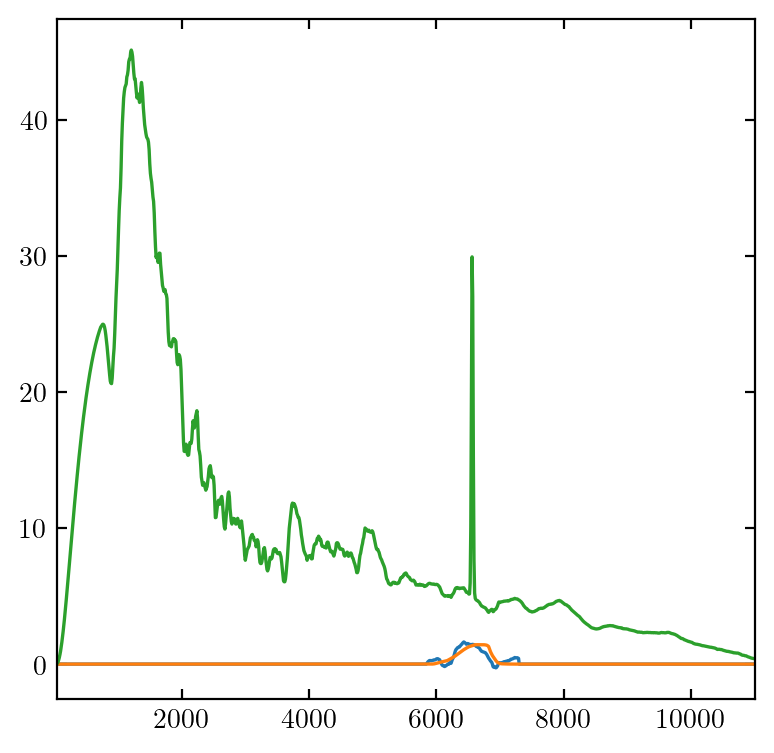

In [44]:
idxlo = idx_closest(Halpha_lo,x)
idxhi = idx_closest(Halpha_hi,x)
#plt.plot(x,y)
#plt.plot(x[idxlo:idxhi],f(x[idxlo:idxhi]),lw=2)

plt.plot(subtracted.wavelen,subtracted.flambda)

#plt.plot(x,y-medfilt(subtracted.flambda,kernel_size=31))

#plt.plot(x,y-medfilt(subtracted.flambda,kernel_size=71)+25.5*gaussian(x))

plt.plot(x,25.5*f2(x))

sig = 30/2.355
gaussian = lambda x: np.exp(-(x-6563)**2/(2*sig**2))

plt.plot(x*(1+0),y-a*f2(x)+a*gaussian(x))
plt.xlim(50,11000)


In [45]:
bandpass_dict.keys()

dict_keys(['FUV', 'NUV', 'u', 'Bcfh12k', 'B', 'g+', 'g', 'Vcfh12k', 'V', 'r', 'r+', 'Rcfh12k', 'i2', 'i', 'i+', 'Icfh12k', 'z', 'z+', 'y', 'J'])

In [46]:
simps(subtracted.flambda,subtracted.wavelen)/simps(gaussian(x),x)

25.62887582337294

In [47]:
a=25.62887582337294

In [48]:
simps(25.65*gaussian(x),x)

819.0447801819705

In [53]:
def add_lines(sed):
    
    new_sed = copy.deepcopy(sed)
    
    # H-alpha
    Halpha_wavelen = 6563
    Halpha_window = [5850,7300]
    
    subtracted = get_subtracted(new_sed,Halpha_window)
    gaussian = lambda x: np.exp(-(new_sed.wavelen-Halpha_wavelen)**2/(2*sig**2))
    scale = simps(subtracted.flambda,subtracted.wavelen)/simps(gaussian(new_sed.wavelen),new_sed.wavelen)
    
    f = line_photometry(new_sed.wavelen,Halpha_wavelen)
    new_sed.flambda -= scale*f(new_sed.wavelen)
    new_sed.flambda += scale*gaussian(new_sed.wavelen)
    
    # H-beta
    Hbeta_wavelen = 4861
    
    gaussian = lambda x: np.exp(-(new_sed.wavelen-Hbeta_wavelen)**2/(2*sig**2))
    scale /= 2.9
    
    f = line_photometry(new_sed.wavelen,Hbeta_wavelen)
    new_sed.flambda -= scale*f(new_sed.wavelen)
    new_sed.flambda += scale*gaussian(new_sed.wavelen)
    
    # O3
    O3_wavelen = 5007
    O3_window = [4400,5600]
    
    subtracted = get_subtracted(new_sed,O3_window,buffer=300)
    subtracted.flambda -= scale*gaussian(new_sed.wavelen)
    gaussian = lambda x: np.exp(-(new_sed.wavelen-O3_wavelen)**2/(2*sig**2))
    scale = simps(subtracted.flambda,subtracted.wavelen)/simps(gaussian(new_sed.wavelen),new_sed.wavelen)
     
    f = line_photometry(new_sed.wavelen,O3_wavelen)
    new_sed.flambda -= scale*f(new_sed.wavelen)
    new_sed.flambda += scale*gaussian(new_sed.wavelen)    
    
    # O2
    O2_wavelen = 3727
    O2_window = [3300,4200]
    
    subtracted = get_subtracted(new_sed,O2_window,buffer=300)
    gaussian = lambda x: np.exp(-(new_sed.wavelen-O2_wavelen)**2/(2*sig**2))
    scale = simps(subtracted.flambda,subtracted.wavelen)/simps(gaussian(new_sed.wavelen),new_sed.wavelen)
    
    f = line_photometry(new_sed.wavelen,O2_wavelen)
    new_sed.flambda -= scale*f(new_sed.wavelen)
    new_sed.flambda += scale*gaussian(new_sed.wavelen)
    
    return new_sed

(50, 9500)

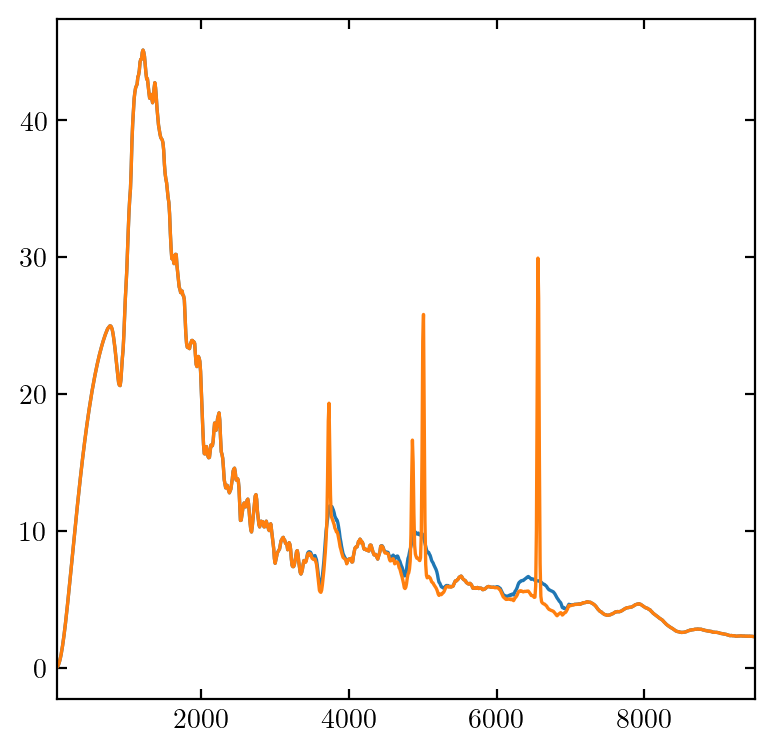

In [58]:
plt.plot(x,y)
new_sed = add_lines(Sed(x,y))
plt.plot(new_sed.wavelen,new_sed.flambda)
plt.xlim(50,9500)